## Forecasting the Value of the Japanese Yen vs USD 

### Time Series Forecasting

In [1]:
#Imports 
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


Bad key "text.kerning_factor" on line 4 in
/Users/renatabal/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


### Return Forecasting: Read Historical Daily Yen Futures Data 
#### In this notebook we will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behaviour 

In [2]:
yen_futures = pd.read_csv(Path('Homework_10-Time-Series_Instructions_Starter_Code_yen.csv'), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2,1
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0,1
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0,1
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0,1
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0,1


In [3]:
 # Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head() 

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336,51473
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206,53860
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649,55699
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944,53111
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763,52072


#### Return Forecasting: Initial Time-Series Plotting

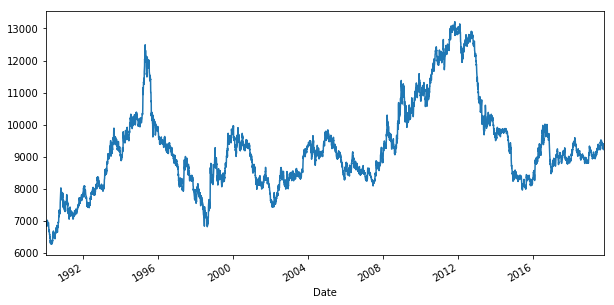

In [4]:
#Plot the Settles column 
yen_futures.Settle.plot(figsize=(10,5))

##### Based on the graph, it appears there is a general trend upward. and there may be some seasonality over a period of 16 years (1996 to 2012). 

### Decomposition Using Hodrick-Prescott Filter 
#### We will now decompose the settle price into a trend and noise. 

In [5]:
import statsmodels.api as sm

In [6]:
ts_noise, ts_trend = sm.tsa.filters.hpfilter(yen_futures['Settle'])

In [7]:
ts_noise.head()

Date
1990-01-02   -61.503967
1990-01-03   -21.799756
1990-01-04    98.942896
1990-01-05    40.776052
1990-01-08    49.689938
Name: Settle_cycle, dtype: float64

In [8]:
ts_trend.head()

Date
1990-01-02    6908.503967
1990-01-03    6908.799756
1990-01-04    6909.057104
1990-01-05    6909.223948
1990-01-08    6909.310062
Name: Settle_trend, dtype: float64

In [9]:
#Create a dataframe of just settle price, and add columns for "noise" and "trend"

In [10]:
yen_futures ["noise"] = ts_noise
yen_futures ["trend"] = ts_trend
yen_futures_new = yen_futures.drop(columns=['Open', 'High', 'Low', 'Last', 'Change', 'Volume', 'Previous Day Open Interest'])

In [11]:
#Plot settle price vs. the trend for 2015 to present 

In [12]:
yen_futures_new.tail()

,Settle,noise,trend
Date,,,
2019-10-09,9338.0,24.939247,9313.060753
2019-10-10,9303.5,-5.868559,9309.368559
2019-10-11,9251.0,-54.454594,9305.454594
2019-10-14,9265.0,-36.423060,9301.423060
2019-10-15,9221.5,-75.844123,9297.344123


In [13]:
yen_futures_new = yen_futures_new.loc["2015-01-01":"2019-10-15"]

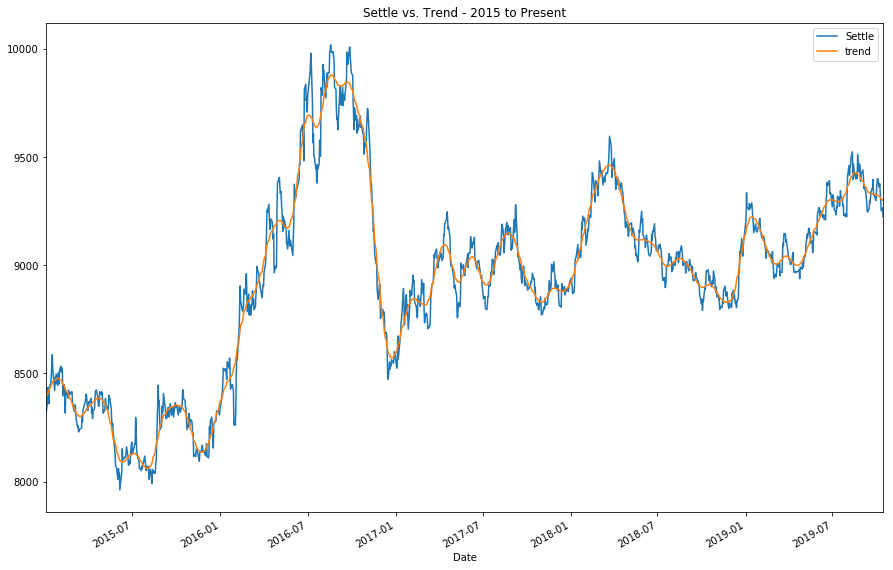

In [14]:
yen_futures_new.plot(y=['Settle', 'trend'], figsize=(15,10), title='Settle vs. Trend - 2015 to Present')

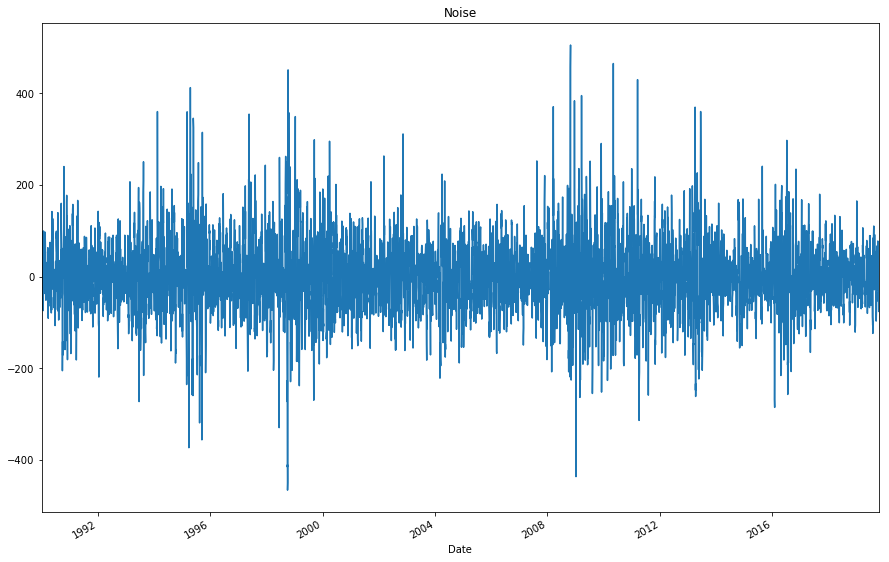

In [15]:
#Plot Settle Noise 
yen_futures.noise.plot(figsize=(15,10), title='Noise')

### Forecasting Returns using an ARMA Model 
####  Using futures Settle Returns we will now estimate an ARMA model, determine if the model is a good fit for the returns data and plot the 5-day forecast

In [16]:
# Create a series using "Settle" price percentage returns, drop nan"s, and check the results:
# replace inf, -inf values with np.nan"s
returns = (yen_futures[['Settle']].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [17]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
import warnings
warnings.filterwarnings('ignore')

In [18]:
#estimate ARMA model using order=(2,1)
model = ARMA(returns.values, order=(2,1))

In [19]:
# Fit the model to the data
results = model.fit()

In [20]:
# Output model summary results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Tue, 23 Feb 2021   AIC                          15798.142
Time:                        11:59:43   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0063      0.008      0.804      0.422      -0.009       0.022
ar.L1.y       -0.3061      1.277     -0.240      0.811      -2.810       2.198
ar.L2.y       -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.y        0.2945      1.277      0.231      0.818      -2.209       2.798
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3367           +0.0000j            3.3367            0.5000
AR.2         -157.2756           +0.0000j          157.2756            0.5000
MA.1           -3.3957           +0.0000j            3.3957            0.5000
-----------------------------------------------------------------------------
"""

#### Based on the model summary results, we have a p-value = 0.811, which is >0.05 indicating that this model is not a good fit. 

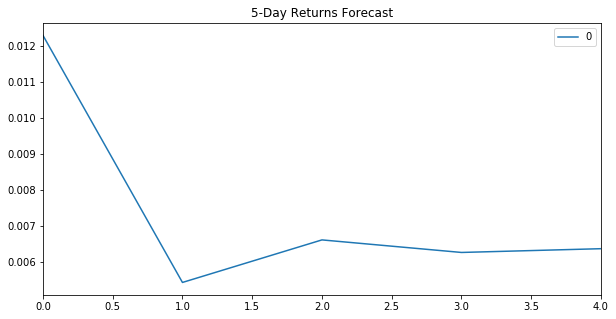

In [21]:
#Plot the 5-day Returns Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(figsize=(10,5), title="5-Day Returns Forecast")

### Forecasting the Settle Price using an ARIMA Model
#### Using the raw Yen settle price we will estimate an ARIMA model, determine if the model is a good fit and plot the 5-day forecast.

In [22]:
#Estimate ARIMA model
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings('ignore')

In [23]:
model = ARIMA(yen_futures['Settle'], order=(5, 1, 1))

In [24]:
#Fit the model and output model results summary
results2 = model.fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Settle   No. Observations:                 7514
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -41944.619
Method:                       css-mle   S.D. of innovations             64.281
Date:                Tue, 23 Feb 2021   AIC                          83905.238
Time:                        11:59:45   BIC                          83960.635
Sample:                             1   HQIC                         83924.259
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3161      0.700      0.452      0.652      -1.056       1.688
ar.L1.D.Settle     0.2820      0.699      0.403      0.687      -1.089       1.653
ar.L2.D.Settle     0.0007      0.016      0.043      0.966      -0.030       0.032
ar.L3.D.Settle    -0.0126      0.012     -1.032      0.302      -0.037       0.011
ar.L4.D.Settle    -0.0137      0.015     -0.889      0.374      -0.044       0.016
ar.L5.D.Settle    -0.0012      0.018     -0.064      0.949      -0.036       0.034
ma.L1.D.Settle    -0.2971      0.699     -0.425      0.671      -1.667       1.073
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8916           -1.3787j            2.3407           -0.1002
AR.2            1.8916           +1.3787j            2.3407            0.1002
AR.3           -2.2690           -3.0213j            3.7785           -0.3525
AR.4           -2.2690           +3.0213j            3.7785            0.3525
AR.5          -11.0358           -0.0000j           11.0358           -0.5000
MA.1            3.3664           +0.0000j            3.3664            0.0000
-----------------------------------------------------------------------------
"""

#### Based on the ARIMA model summary results, we have a p-value = 0.687, which is >0.05 indicating that this model is not a good fit. 

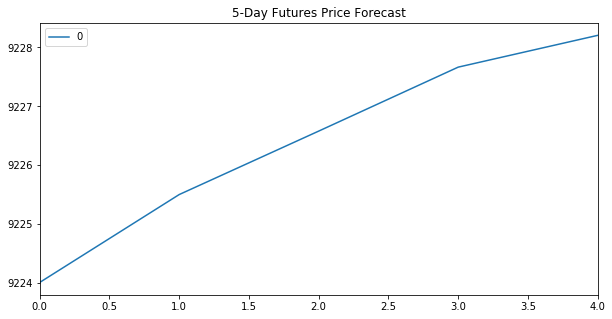

In [25]:
#Plot the 5-day Returns Forecast
pd.DataFrame(results2.forecast(steps=5)[0]).plot(figsize=(10,5), title="5-Day Futures Price Forecast")

### Volatility Forecasting with GARCH 
#### Now we will forecast the near-term volatility of Japenese Yen futures returns which can help us to predict volatility for trading in derivatives or to quantity our maximum loss. Creating a GARCH model, we will determine if the model is a good fit for the data and plot the 5-day forecast of the volatility.

In [26]:
#Imports
import arch
from arch import arch_model

In [27]:
#Estimate a GARCH model, fit the model and summarize the model results 
model = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)
results3 = model.fit(disp="off")
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.93
Distribution:                  Normal   AIC:                           14931.9
Method:            Maximum Likelihood   BIC:                           14959.6
                                        No. Observations:                 7514
Date:                Tue, Feb 23 2021   Df Residuals:                     7514
Time:                        11:59:46   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.2896e-03  2.057e-03      2.085  3.708e-02  [2.571e-04,8.322e-03]
alpha[1]       0.0381  1.282e-02      2.970  2.974e-03  [1.295e-02,6.321e-02]
alpha[2]       0.0000  1.703e-02      0.000      1.000 [-3.338e-02,3.338e-02]
beta[1]        0.9536  1.420e-02     67.135      0.000      [  0.926,  0.981]
=============================================================================

Covariance estimator: robust
"""

#### Based on the GARCH model summary results, we have a p-value <0.05 indicating that this model is a good fit. 

In [28]:
#Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [29]:
#Create a 5-day forecast
forecast_horizon = 5 
forecasts = results3.forecast(start='2019-10-15', horizon=forecast_horizon)

In [30]:
 # Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.434048,7.475745,7.516867,7.557426,7.597434


In [31]:
#Transpose the forecast for plotting
final = intermediate.dropna().T
final

Date,2019-10-15 00:00:00
h.1,7.434048
h.2,7.475745
h.3,7.516867
h.4,7.557426
h.5,7.597434


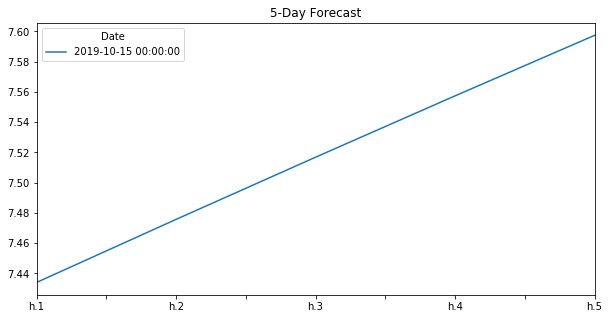

In [32]:
#Plot forecast
final.plot(figsize=(10,5), title="5-Day Forecast")

### Conclusions
#### 1. Based on the above time series analyses, I would not buy yen now. From the model output results for both the ARMA and the ARIMA models,  their p-values are greater than 0.05 therefore, the coefficient for the autoregressive term is not statistically significant and these models do not appear to be a good fit for our data. 
#### 2. In addition, the output of the GARCH Forecast Model shows an upward trend indicating that the exchange rate risk of the yen is expected to increase. Personally, I would not be comfortable with this level of risk. 
#### 3. Based on the model evaluations, I would not feel confident solely using these models for trading. 

## Regression Analysis: Seasonal Effects with Sklearn Linear Regression
#### In this notebook, a Scikit-Learn linear regression model will be built to predict Yen futures returns with lagged Yen futures returns and categorical seasonal effects. We will also determine if the model performs better or worse on out-of-sample data vs in-sample data. 

In [33]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

In [34]:
yen_futures = pd.read_csv("Homework_10-Time-Series_Instructions_Starter_Code_yen.csv", index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head() 

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2,1
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0,1
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0,1
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0,1
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0,1


In [35]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336,51473
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206,53860
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649,55699
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944,53111
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763,52072


### Data Preparation

#### Returns

In [36]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = yen_futures[['Settle']].pct_change() * 100
returns = returns.replace(-np.inf, np.nan).dropna()

In [37]:
yen_futures['Return'] = returns
yen_futures = yen_futures.dropna()
yen_futures.tail()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return
Date,,,,,,,,,
2019-10-09,9381.0,9391.5,9330.5,9343.5,38.5,9338.0,99153,145470,-0.410601
2019-10-10,9343.5,9380.5,9293.5,9301.0,34.5,9303.5,159397,144474,-0.369458
2019-10-11,9308.5,9309.0,9240.0,9267.0,52.5,9251.0,158810,147471,-0.564304
2019-10-14,9259.0,9292.0,9250.5,9261.0,14.0,9265.0,69457,153902,0.151335
2019-10-15,9264.5,9280.0,9216.5,9220.0,43.5,9221.5,108342,151564,-0.469509


#### Lagged Returns

In [38]:
# Create a lagged return using the shift function
yen_futures ['Lagged Returns'] = returns.shift()
yen_futures = yen_futures.dropna()
yen_futures.tail()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return,Lagged Returns
Date,,,,,,,,,,
2019-10-09,9381.0,9391.5,9330.5,9343.5,38.5,9338.0,99153,145470,-0.410601,0.170931
2019-10-10,9343.5,9380.5,9293.5,9301.0,34.5,9303.5,159397,144474,-0.369458,-0.410601
2019-10-11,9308.5,9309.0,9240.0,9267.0,52.5,9251.0,158810,147471,-0.564304,-0.369458
2019-10-14,9259.0,9292.0,9250.5,9261.0,14.0,9265.0,69457,153902,0.151335,-0.564304
2019-10-15,9264.5,9280.0,9216.5,9220.0,43.5,9221.5,108342,151564,-0.469509,0.151335


#### Train Test Split

In [39]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = yen_futures[:'2017']
test = yen_futures['2018':]

In [40]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# y_train (training set using just the "y" variable, i.e., "Futures Return"), y_test (test set of just the "y" variable):
X_train = train['Lagged Returns'].to_frame()
X_test = test['Lagged Returns'].to_frame()
y_train = train['Return']
y_test = test['Return']

In [41]:
X_train.head()

,Lagged Returns
Date,
2014-02-18,0.409123
2014-02-19,-0.427829
2014-02-20,-0.020460
2014-02-21,0.020465
2014-02-24,-0.204604


## Linear Regression Model 

In [42]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [43]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
predictions = model.predict(X_test)
Results = y_test.to_frame() 
Results["Predicted Return"] = predictions 

In [44]:
Results.head()

,Return,Predicted Return
Date,,
2018-01-02,0.297285,-0.009599
2018-01-03,-0.240479,-0.010033
2018-01-04,-0.213028,-0.006807
2018-01-05,-0.353933,-0.006971
2018-01-08,0.062017,-0.006126


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff20b603650>,
      dtype=object)

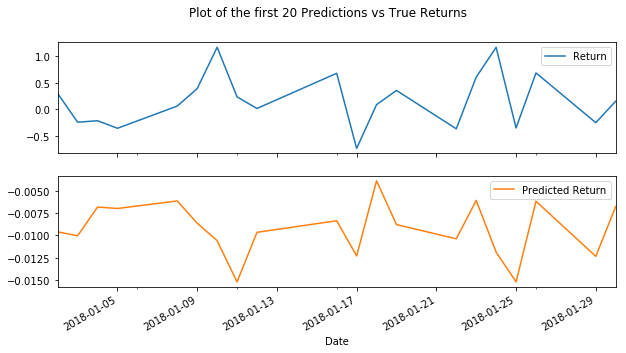

In [45]:
# Plot the first 20 predictions vs the true values
Results[:20].plot(figsize=(10,5),subplots=True, title="Plot of the first 20 Predictions vs True Returns")

### Out-of-Sample Performance
#### Evaluate the model using "out-of-sample" data (X_test and y_test)

In [46]:
from sklearn.metrics import mean_squared_error

In [47]:
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse = mean_squared_error(
    Results["Return"],
    Results["Predicted Return"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse = np.sqrt(mse)
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {rmse}")

Out-of-Sample Root Mean Squared Error (RMSE): 0.41545437184712763


### In Sample Performance 
#### Evaluate the model using in-sample data (X_train and y_train)

In [48]:
in_sample_results = y_train.to_frame()

# Add a column of \"in-sample\" predictions to that dataframe:  
in_sample_results['In-sample Predictions'] = model.predict(X_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_mse = mean_squared_error(
in_sample_results['Return'],
in_sample_results['In-sample Predictions'])

In [49]:
in_sample_rmse = np.sqrt(in_sample_mse)
print(f"In-Sample Root Mean Squared Error (RMSE): {in_sample_rmse}")

In-Sample Root Mean Squared Error (RMSE): 0.5962037920929946


### Conclusions
#### The model performs better with out-of-sample data (training data) because it has a RMSE value of .415 as opposed to the RMSE of .596 for the in-sample data.